<a href="https://colab.research.google.com/github/olgapy59/-/blob/main/Olist1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
customer = pd.read_csv('olist_customers_dataset.csv')
geo = pd.read_csv('olist_geolocation_dataset.csv')
item = pd.read_csv('olist_order_items_dataset.csv')
payment = pd.read_csv('olist_order_payments_dataset.csv')
review = pd.read_csv('olist_order_reviews_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')
product_list = pd.read_csv('olist_products_dataset.csv')
seller = pd.read_csv('olist_sellers_dataset.csv')
product_category = pd.read_csv('product_category_name_translation.csv')
MQL = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')
closed_deals = pd.read_csv('olist_closed_deals_dataset.csv')

In [3]:
list_of_df = [customer,
              geo,
              item,
              payment,
              review,
              order,
              product_list,
              seller,
              product_category,
              closed_deals,
              MQL]

for df in list_of_df:
    print(list(df.columns), len(df.columns))

['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'] 5
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'] 5
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'] 7
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value'] 5
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'] 7
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'] 8
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'] 9
['seller_id', 'seller_zip_code_prefix', 'sell

In [4]:
datasets = [customer, geo, item, payment, review, order, product_list, seller, product_category]
titles = ["customers", "geolocation", "items", "payments", "reviews", "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col in data.columns ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [data.duplicated().sum() for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


In [5]:
 # RFM ANALYSIS
 # RECENCY
 # получение последней даты покупки для каждого пользователя
recency_table = customer.merge(order, on ="customer_id")
recency_table = recency_table.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()
# конвертируем в тип даты и времени
recency_table['order_purchase_timestamp'] = pd.to_datetime(recency_table['order_purchase_timestamp'])
# вычисляем текущий день
current_day = pd.to_datetime(max(order['order_purchase_timestamp']))
# вычислить дни между
recency_table['days_between'] = (current_day - recency_table['order_purchase_timestamp']).apply(lambda x: int(str(x).split()[0]))
# функция def, которая оценивает данные
def scoring(x):
    # вычисляем квантили
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # помечаем базу данных значением квантиля
    def labeling(x):
        if x < quan_val_list[0]: return 1
        elif x < quan_val_list[1]: return 2
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 4
        else: return 5

    return x.apply(labeling)

recency_table['recency_score'] = scoring(recency_table['days_between'])
recency_table

,customer_unique_id,order_purchase_timestamp,days_between,recency_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,2
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,5
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,4
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,4
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,495,5
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,310,3
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,617,5
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,168,2


In [6]:
# FREQUENCY
# объединение df
frequency_table = customer.merge(order, on="customer_id")
# получение интересующей информации
frequency_table = frequency_table.groupby('customer_unique_id').agg({
    "order_purchase_timestamp": ['min', 'max'],
    "order_id": 'count'
}).reset_index()
# изменить столбцы
frequency_table.columns = ['customer_unique_id', 'min', 'max', 'count']
# изменить тип данных
frequency_table['max'] = pd.to_datetime(frequency_table['max'])
frequency_table['min'] = pd.to_datetime(frequency_table['min'])
# дней между первым и последним днем покупки
frequency_table['days_between'] = (frequency_table['max'] - frequency_table['min']).apply(lambda x: int(str(x).split()[0]))
frequency_table['days_between'].value_counts()
# избавиться от клиента, совершающего единоразовую покупку
frequency_table = frequency_table[frequency_table['days_between']>0]
# рассчитать Purchase_rate
frequency_table['purchase_rate'] = frequency_table['count'] / frequency_table['days_between']
# оценка Purchase_rate
frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])

<ipython-input-6-ba93f74a0b77>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_table['purchase_rate'] = frequency_table['count'] / frequency_table['days_between']
<ipython-input-6-ba93f74a0b77>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])


In [7]:
# MONETARY
monetary_table = payment.merge(order, on="order_id").merge(customer, on="customer_id")
monetary_table = monetary_table.groupby('customer_unique_id').agg({'payment_value':'sum'}).reset_index()
monetary_table['monetary_score'] = scoring(monetary_table['payment_value'])
monetary_table

,customer_unique_id,payment_value,monetary_score
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1
2,0000f46a3911fa3c0805444483337064,86.22,2
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,196.89,4
...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,5
96091,fffea47cd6d3cc0a88bd621562a9d061,84.58,2
96092,ffff371b4d645b6ecea244b27531430a,112.46,3
96093,ffff5962728ec6157033ef9805bacc48,133.69,4


In [9]:
 # COMBINE ALL TOGETHER
final_table = recency_table.merge(monetary_table, on = 'customer_unique_id').merge(frequency_table, on='customer_unique_id')
final_table = final_table[['customer_unique_id', "recency_score", "frequency_score","monetary_score"]]
final_table['frequency_monetary_score'] = scoring(final_table['frequency_score'] + final_table['monetary_score'])
final_table = final_table[['customer_unique_id', 'recency_score', 'frequency_monetary_score']]

segment_dict = {# hibernating
(1,1):"hibernating",
(1,2):"hibernating",
(2,1):"hibernating",
(2,2):"hibernating",
# about to sleep
(3,1):"about to sleep",
(3,2):"about to sleep",
# promising
(4,1):"promising",
# new customer
(5,1):"new customer",
# potential customers
(4,2):"potential",
(4,3):"potential",
(5,2):"potential",
(5,3):"potential",
# need attion
(3,3):"need attion",
# at risk
(1,3):"at risk",
(1,4):"at risk",
(2,3):"at risk",
(2,4):"at risk",
# do not lose
(1,5):"do not lose",
(2,5):"do not lose",
# loyal customer
(3,4):"loyal",
(3,5):"loyal",
(4,4):"loyal",
(4,5):"loyal",
# champions
(5,4):"champions",
(5,5):"champions"}

final_table['segment'] = final_table.apply(lambda x:
                  segment_dict[(x['recency_score'],x['frequency_monetary_score'])]
                  , axis = 1
                  )

In [10]:
final_data = final_table['segment'].value_counts()
final_data = final_data.apply(lambda x: x*100/np.sum(final_data.values)).sort_values(ascending=True)

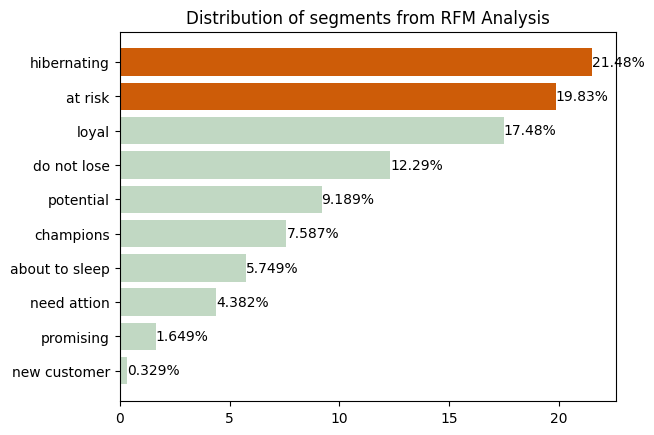

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

color_map = ["#C1D8C3"] * len(final_data)
color_map[-2] = color_map[-1] = '#CD5C08'

ax.barh(
    y =  final_data.index,
    width =  final_data.values,
    color = color_map
)

ax.set_title('Distribution of segments from RFM Analysis')

for ind, val in final_data.items():
    ax.annotate(
        str(val)[:5] + "%",
        xy = (val,ind), va='center'
    )
